In [1]:
bayesplay::loadpackages()

# Bayes rule 

I've left talking about Bayes rule until now, because I think you can understand the concept of the Bayes factor without it, and because I wanted to emphasise the idea that the Bayes factor is a ratio of **two weighted averages**. However, now that we have this simple understanding, I'm hoping to deepen your understanding a bit by introducing Bayes rule. This deeper understanding of Bayes rule will also help use understand some of the topic we'll cover later in the course. 

## What is Bayes rule

Bayes rule follows straightforwardly from the axioms of conditional probability. In this sense, there's nothing particularly "Bayesian" about it in that both Frequentists and Bayesians can, and do, make use of the concept of conditional probability.

When you encounter Bayes rule in a frequentist context, it often takes the following form:

$$p(A|B) = \frac{p(B|A)p(A)}{p(B)}$$

or 

$$p(A|B) = \frac{p(B|A)p(A)}{p(B|A)p(A) + p(B|\neg{}A)p(\neg{}A)}$$

In this form, it typically explained by way of an example usually involving some kind of a test. In classic examples, the context if *often* a test for a rare disease. It is then shown that Bayes rule can be used to calculate the probability that the **positive** test indicates the **presence** of the disease [p(disease present| positive test)], by taking into account the **sensitivity** of the test [p(positive test | disease present)], the prevalence of the disease [p(disease)], and the probability of the test returning a positive result irrespective of the presence of the disease [p(positive)].

In the context of Bayesian inference, it is often given in a  slightly different form:

$$p(A|B) \propto{} P(B|A) \cdot{} P(A)$$

or

$$p(\theta|Y) \propto{} \mathcal{L}(\theta|Y) \cdot{}p(\theta)$$

In this form it is usually reads as "the posterior probability is proportional to the likelihood times the prior". The proportional form drops the denominator, which for a continuous parameter is given as:

$$p(Y) = \int_\Theta p(Y|\theta)p(\theta)d(\theta)$$ 

Integrals are generally difficult to work out, so they're often best avoided! We'll see in the section on parameter estimation that while it's not always possible to work out the posterior, we can just **draw samples from it** without needing to solve the integral.

Both of these forms, however, obscure the relationship between **Bayes** and  **prediction**. 

Following [Rouder and Morey (2019)](https://doi.org/10.1080/00031305.2017.1341334), I think it's useful to present Bayes rule in the ratio form:

$$\frac{\pi(\theta|Y)}{\pi({\theta})}=\frac{p(Y|\theta)}{p(Y)}$$

The ratio form relates our "beliefs" about parameters $\frac{\pi(\theta|Y)}{\pi({\theta})}$ to probabilities about data $\frac{p(Y|\theta)}{p(Y)}$. Or put another way, it relates **beliefs** and **evidence** to **predictions**. To understand how this is the case, we'll examine the example given by [Rouder and Morey (2019)](https://doi.org/10.1080/00031305.2017.1341334). 

To explore this formula we'll first have to set two things. First, we'll need to set what our observation is—that is, our **data**. This will just be the number of heads ($x$) we've observed after $n$ flips. The second thing we need to set if our **prior**. This is just the weights that we set in the previous section, and the **prior** represents our *"beliefs"* about plausible values for the parameter (in our case, the bias of the coin) **before** seeing the data (more on whether priors represent beliefs in the next section). We'll represent our prior with a $\mathbf{Beta}$ distribution, because this has some convenient mathematical properties (again, more on that in the next section). By changing the two parameters of the $\mathbf{Beta}$ distribution ($\alpha$ and $\beta$) you can assign more or less prior mass to the extreme (i.e., $\theta$ = 0 and $\theta$ = 1). When the values are the same, the distribution will be symmetrical and then they're different the distribution with be asymmetrical. 

For our simple coin flip example, we'll just be able to calculate the posterior directly. This posterior represents what we believe about the parameter **after** seeing the data. 

In [26]:
# 1

# Set the observation
# This takes two parameters
# X: The number of heads
# N: The number of flips
X = 8
N = 10

# set the prior
# We'll use a Beta distribution as our prior
# The beta distribution takes two parameters (α [alpha_prior] and β [beta_prior])
alpha_prior = 1
beta_prior = 1
# calculate summary of prior
prior_mean = alpha_prior / (alpha_prior + beta_prior)
prior_mode = case_when(alpha_prior == beta_prior & alpha_prior == 1 ~ "any value in (0,1)",
          alpha_prior == beta_prior & alpha_prior <1 ~ "bimodal {0,1}", 
          alpha_prior <= 1 & beta_prior > 1 ~ "0",
          alpha_prior > 1 & beta_prior <= 1 ~ "1",
          TRUE ~ round((alpha_prior - 1) / (alpha_prior + beta_prior - 2),2) %>% as.character() )

prior_var = (alpha_prior * beta_prior) / ( ((alpha_prior + beta_prior)^2) * (alpha_prior + beta_prior + 1)  )


glue("Our data is {X} heads in {N} flips") %>%
IRdisplay::display_markdown()

glue("The prior is a $\\mathrm{{Beta}}$({alpha_prior}, {beta_prior}) distribution   
The mean (expected value): $\\theta$ = {round(prior_mean,2)}   
The mode (max probablity density): $\\theta$ = {prior_mode}   
The variance: {round(prior_var,3)}") %>% 
IRdisplay::display_markdown()

Our data is 8 heads in 10 flips

The prior is a $\mathrm{Beta}$(1, 1) distribution   
The mean (expected value): $\theta$ = 0.5   
The mode (max probablity density): $\theta$ = any value in (0,1)   
The variance: 0.083

In [27]:
# 2

# define a function for the prior
prior_func = function(theta, alpha_prior,beta_prior){
    dbeta(x = theta, shape1 = alpha_prior, shape2 = beta_prior)}


# create a tibble to hold the plot data
prior_df = tibble(theta = seq(0,1,.01)) %>%
mutate(density = map_dbl(theta, function(x) prior_func(theta = x, alpha_prior, beta_prior))) 


In [28]:
# 3

# calculate the posterior
# because the beta distribution is a conjugate prior for the binomial 
# we can directly compute the posterior, which will also be a 
# Bet distribution


# define a function for the posterior
posterior_func = function(theta, X, N, alpha_prior, beta_prior){
    dbeta(x = theta, shape1 = alpha_prior + X, shape2 = beta_prior + N - X)
}


# create a tibble to hold the plot data
posterior_df = tibble(theta = seq(0,1,.01)) %>%
mutate(density = map_dbl(theta, function(x) posterior_func(theta = x, X, N, alpha_prior, beta_prior))) 

# calculate summary of posterior
alpha_posterior = alpha_prior + X                      
beta_posterior = beta_prior + N - X

posterior_mean = alpha_posterior / (alpha_posterior + beta_posterior)
posterior_mode = (alpha_posterior - 1) / (alpha_posterior + beta_posterior - 2)
posterior_var = (alpha_posterior * beta_posterior) / 
                         ( ((alpha_posterior + beta_posterior)^2) * (alpha_posterior + beta_posterior + 1)  ) 
                         
glue("The posterior is a $\\mathrm{{Beta}}$({alpha_posterior}, {beta_posterior}) distribution   
The mean (expected value): $\\theta$ = {round(posterior_mean,2)}   
The mode (max probablity density): $\\theta$ = {round(posterior_mode,2)}   
The variance: {round(posterior_var,3)}") %>% 
IRdisplay::display_markdown()                         
                                          

The posterior is a $\mathrm{Beta}$(9, 3) distribution   
The mean (expected value): $\theta$ = 0.75   
The mode (max probablity density): $\theta$ = 0.8   
The variance: 0.014

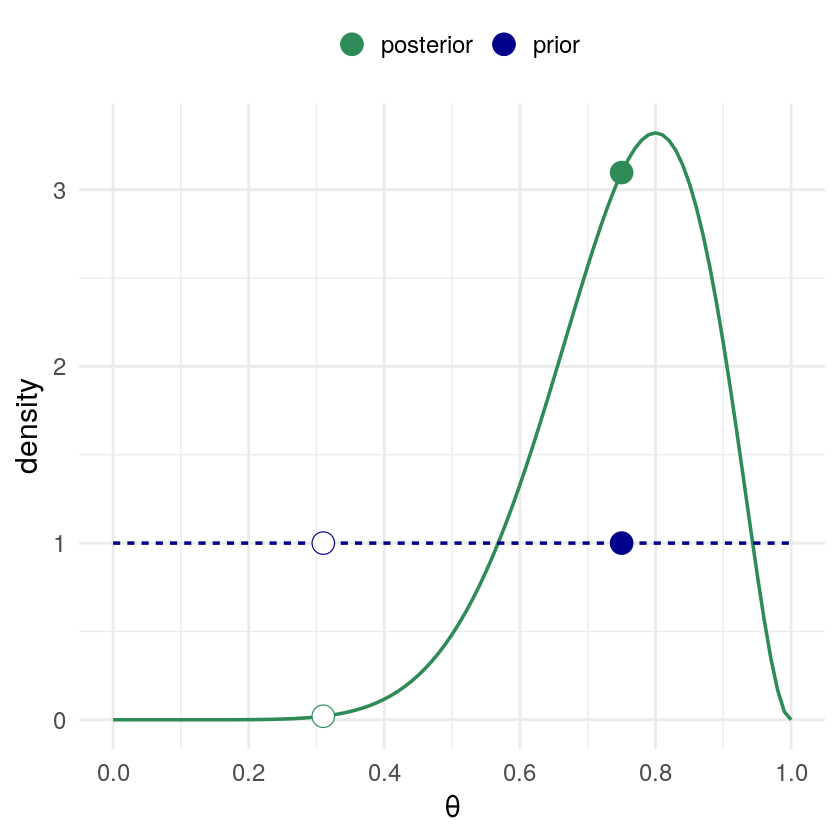

In [29]:
# 4

# plot the prior and posterior
combined_df = prior_df %>% full_join(posterior_df, by = 'theta', suffix = c(".prior",".posterior")) %>%
mutate(`prior > posterior` = density.prior > density.posterior) %>%
pivot_longer(cols = c("density.prior","density.posterior"), names_to = "type", values_to = "density")


ggplot(combined_df, aes(x = theta, y = density, colour = type, linetype = type)) + geom_line(size = 1) +
scale_colour_manual(values = c(density.posterior = "seagreen", density.prior  = "darkblue"),
                   labels = c(density.posterior = "posterior", density.prior  = "prior"), 
                   name = NULL) + 
scale_linetype(guide = "none") +
geom_point(data = combined_df %>% group_by(`prior > posterior`) %>% mutate(mid = abs(median(theta) - theta)) %>%
filter(mid == min(mid)) %>% slice(1:2), 
          mapping = aes(x = theta, y = density, colour = type, shape = `prior > posterior`), 
           fill = "white", size = 6) + 
scale_shape_manual(values = c("TRUE" = 21, "FALSE" = 19), guide = "none") +
scale_x_continuous(name = "θ", breaks = seq(0,1,.2)) + theme_minimal(18) + theme(legend.position = "top")

Once we plot the **prior** and the **posterior** together we'll see that for some values of $\theta$ seeing the data resulted in us *believing* that that value of $\theta$ is *more probable*. For other values, we now *believe* that that value of $\theta$ is *less probable* (in the plots, a value that is *less probable* after seeing the data is shown with empty point and a value that is *more probable* after seeing the data is shown with a filled point).

For each value of the parameter we can examine whether the data resulted in us believing that that value of the parameter is more or less probable. We can call this the **strength of evidence from the data about $\theta$**. We can calculate this by just calculating the relative difference between the prior and the posterior—that is, by calculating $\frac{\pi(\theta|Y)}{\pi(\theta)}$.


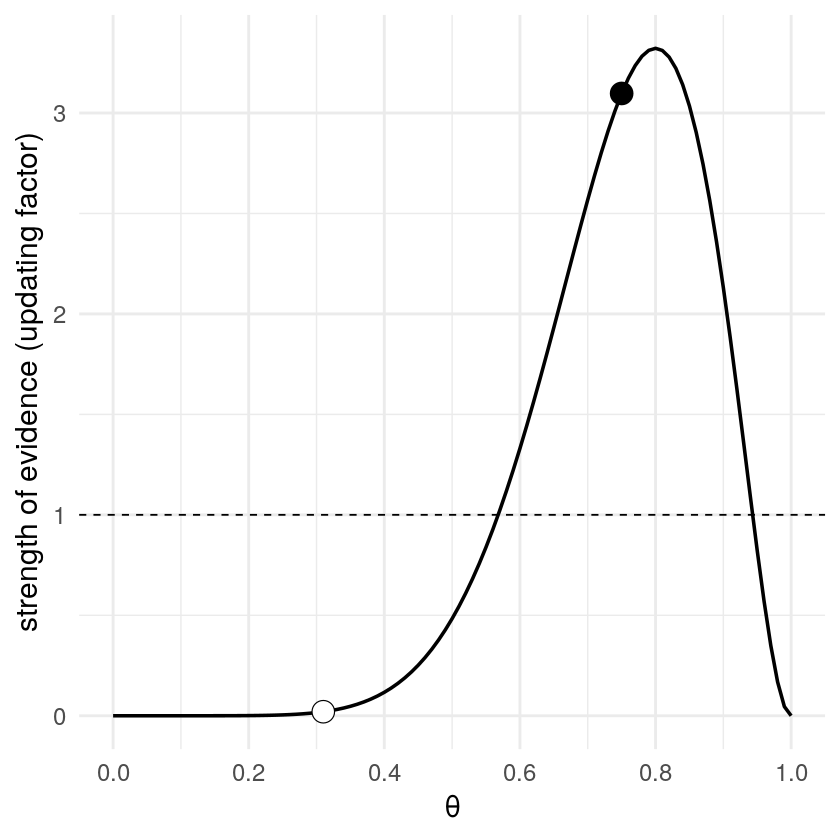

In [30]:
# 5

# strength of evidence for each value of theta

updating_df = combined_df %>% pivot_wider(names_from = "type", values_from = "density") %>% 
mutate(updating = density.posterior / density.prior) 

ggplot(updating_df, aes(x = theta, y = updating)) + geom_line(na.rm = TRUE, size = 1) + 
geom_point(data = updating_df %>% group_by(`prior > posterior`) %>% mutate(mid = abs(median(theta) - theta)) %>%
filter(mid == min(mid)) %>% slice(1), 
          mapping = aes(x = theta, y = updating, shape = `prior > posterior`), 
           fill = "white", size = 6) +
scale_shape_manual(values = c("TRUE" = 21, "FALSE" = 19), guide = "none") + 
scale_y_continuous(name = "strength of evidence (updating factor)") + geom_hline(yintercept = 1, linetype = 2) + 
scale_x_continuous(name = "θ", breaks = seq(0,1,.2)) + theme_minimal(18)

We can now turn our attention to the data and we can ask: "what is the probability of different observations **assuming** different values of $\theta$?". This can be done with a simulation (like in our earlier examples); however, I know that it follows a $\mathbf{Binomial}$ distribution, so I can just generate it for different assumed values of $\theta$.


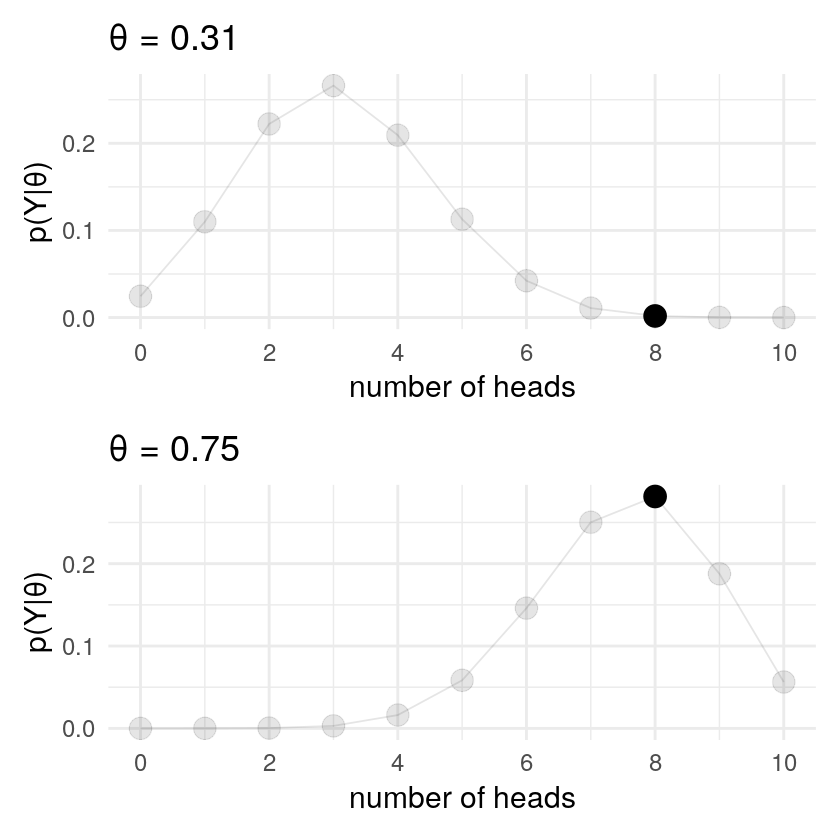

In [31]:
# 6

thetas = updating_df %>% group_by(`prior > posterior`) %>% mutate(mid = abs(median(theta) - theta)) %>%
filter(mid == min(mid)) %>% slice(1) %>% arrange(theta) %>% select(`prior > posterior`,theta)



conditional_df = map_df(thetas$theta, function(t)
tibble(x = 0:N, 
       prob = dbinom(x = 0:N, size = N, prob = t), 
      theta = t)) %>%
       mutate(ob = x == X) %>% group_split(theta)
       
       

conditional_plots = map(conditional_df, 
    function(d) ggplot(data = d, aes(x = x, y = prob)) + geom_point(aes(alpha = ob), size = 6) + 
       geom_line(alpha = .1) + scale_alpha_manual(values = c(.1,1), guide = "none") +
       scale_x_continuous(breaks = seq(0,N,2), name = "number of heads") +
       scale_y_continuous(name = "p(Y|θ)") + labs(title = glue("θ = {d$theta[1]}")) + theme_minimal(18))
                        
patchwork::wrap_plots(conditional_plots,nrow = 2)
     

The next concept, $p(Y)$, or the **marginal probability**,  is a slightly tricky concept: $p(Y)$ is the probability of observing our data independent of whatever value $\theta$ might take. Often this value is ignored, especially in the context of parameter estimation (as you'll see in later sections). In fact, this value isn't present in the "proportional" formulation of Bayes rule; however, understanding $p(Y)$ is extremely useful in the context of **Bayes factors**.   

The **marginal probability** distribution/mass plot can be more readily conceptualised as the predictions a model ($\mathcal{M}_I$) makes about the data. We can generate this by seeing what data is predicted by each value of $\theta$ where $\theta$ itself has a probability distribution specified by $\pi(\theta)$. This concept is maybe easiest to understand when we consider a uniform prior where each value of $\theta$ is equally probably. Then we can ask, what is the probability of observing a specific outcome $Y$  independent of the value of $\theta$ (or, averaged across all possible values of $\theta$. This is just $\frac{1}{n}$, where $n$ is the number of possible outcomes. In our coin flip example, there are 11 possible outcomes—0 heads, 1 head, 2 heads,... 10 heads. So $p(Y)$ would be $\frac{1}{11}$ for any outcome. Or phrased another way, we can say that, without knowing $\theta$, but knowing that every value of $\theta$ is equally probably, we can predict that any observation, such as our specific observation, would occur with a probability of $\frac{1}{11}$. A very important thing to note about the *marginal probability distribution* is that it must sum to 1. We'll see in the example below, that for different priors ($\pi(\theta)$), the pattern see in the marginal distribution changes, but it always sums to 1. This means that when some observations become **more** probable, other observations must become **less** probable. 

In the table below, you'll see how the **marginal probability** is calculated for each observation. The table just shows the calculation for our specific observation—that is, our $p(Y)$. Note that the accuracy of our estimate for $p(Y)$ depends on how many values of $\theta$ we average across. This means that for a uniform prior, the limit of our estimate will approach $\frac{1}{11}$ when the number of values of $\theta$ that we average across approaches infinity. 

In [32]:
# 7

resolution = 1001 # set the resolution - this determines how many possible values of theta are considered. 
                # to get an accurate estimate of theta, you need to consider every possible value of theta
                # adjust the value highter to get a more accurate estimate of p(Y)

theta_range = seq(0,1,length.out = resolution)

marginal_prob_tbl = tibble(theta = theta_range, x = X, n = N,
cond_prob = map_dbl(theta_range, function(t) dbinom(x = X,size = N,prob = t)),
prior_prob = map_dbl(theta_range, function(t) dbeta(x = t, shape1 = alpha_prior, shape2 = beta_prior))) %>%
                     mutate(prior_prob = prior_prob / sum(prior_prob))

                     
marginal_prob_tbl = marginal_prob_tbl %>% mutate(margin = cond_prob * prior_prob)
                         
marginal_prob_tbl %>% slice(seq(1,resolution,length.out = 11)) %>% set_colnames(c("$\\theta$","$X$","$N$","$p(Y|\\theta$)",
                                     "$\\pi(\\theta)$","$p(Y,\\theta,\\pi)$")) %>% 
                    knitr::kable(format = "html", digits = 3) %>% 
                    kableExtra::kable_styling(full_width = T) %>% as.character() %>% IRdisplay::display_html()  

glue::glue("$p(Y)$ = {marginal_prob_tbl %>% pull(margin) %>% sum() %>% round(3)}") %>% 
                     IRdisplay::display_markdown() 
                     


$\theta$,$X$,$N$,$p(Y|\theta$),$\pi(\theta)$,"$p(Y,\theta,\pi)$"
0.0,8,10,0.000,0.001,0
0.1,8,10,0.000,0.001,0
0.2,8,10,0.000,0.001,0
0.3,8,10,0.001,0.001,0
0.4,8,10,0.011,0.001,0
0.5,8,10,0.044,0.001,0
0.6,8,10,0.121,0.001,0
0.7,8,10,0.233,0.001,0
0.8,8,10,0.302,0.001,0
0.9,8,10,0.194,0.001,0


$p(Y)$ = 0.091

The table just shows the marginal probability for our observation, but in the figure below we can plot the marginal distribution which considers every possible observation. This allows us to look of the entire range of possible observations and see which are more or less probable. These are the predictions our model makes. 


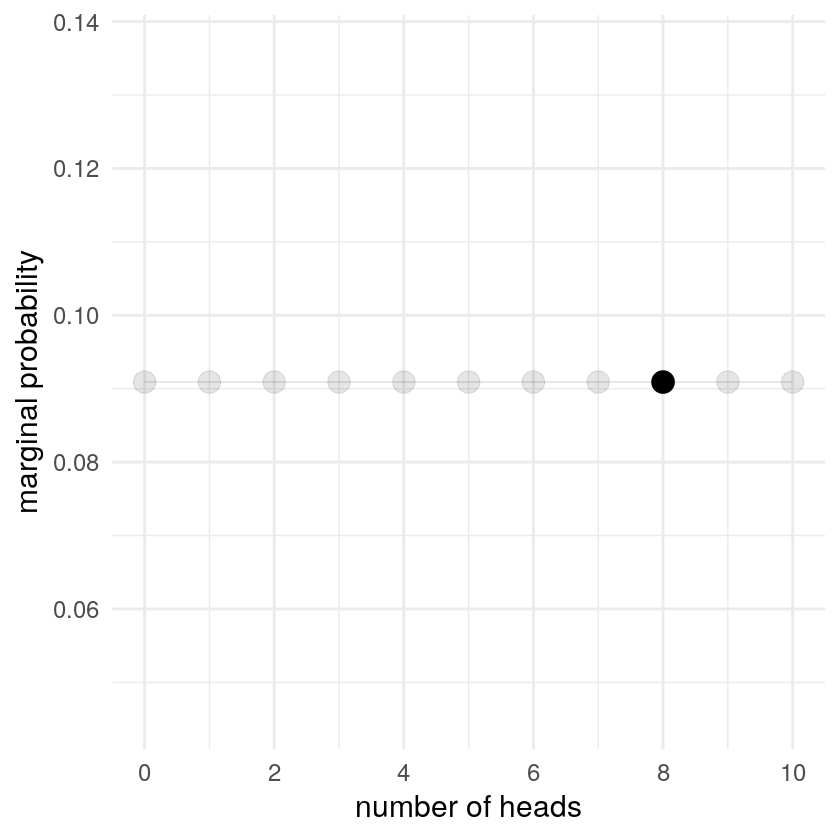

In [33]:
# 8

marginal_func = function(theta,X,N,alpha_prior,beta_prior) 
    dbinom(x = X, size = N, prob = theta) * dbeta(x = theta, shape1 = alpha_prior, shape2 = beta_prior)


marginal_df = tibble(x = 0:N,
marginal_prob = map_dbl(.x = 0:N, .f = function(x) integrate(f = marginal_func, lower = 0, upper = 1, 
                                             x, N, alpha_prior, beta_prior)$value), ob = x == X)
                        
general_model_plot = marginal_df %>% ggplot(aes(x = x, y = marginal_prob)) + geom_point(aes(alpha = ob), size = 6) + 
geom_line(alpha = .1) +  scale_alpha_manual(values = c(.1,1), guide = "none") +
       scale_x_continuous(breaks = seq(0,N,2), name = "number of heads") +
scale_y_continuous(name = "marginal probability")  + theme_minimal(18)
general_model_plot

We can compare the marginal probability of our observation $p(Y)$ with the conditional probability $p(Y|\theta)$ — that is, conditional on a specific value of $\theta$. The ratio of these two $\frac{p(Y|\theta)}{p(Y)}$ is the predictive accuracy for our data that gained by considering $\theta$. 

The following plot simply shows the conditional probability of the data give different values of the paramater (labelled **conditional**) and the marginal probability or the probability of the data irrespective of the value of the parameter (labelled **marginal**).


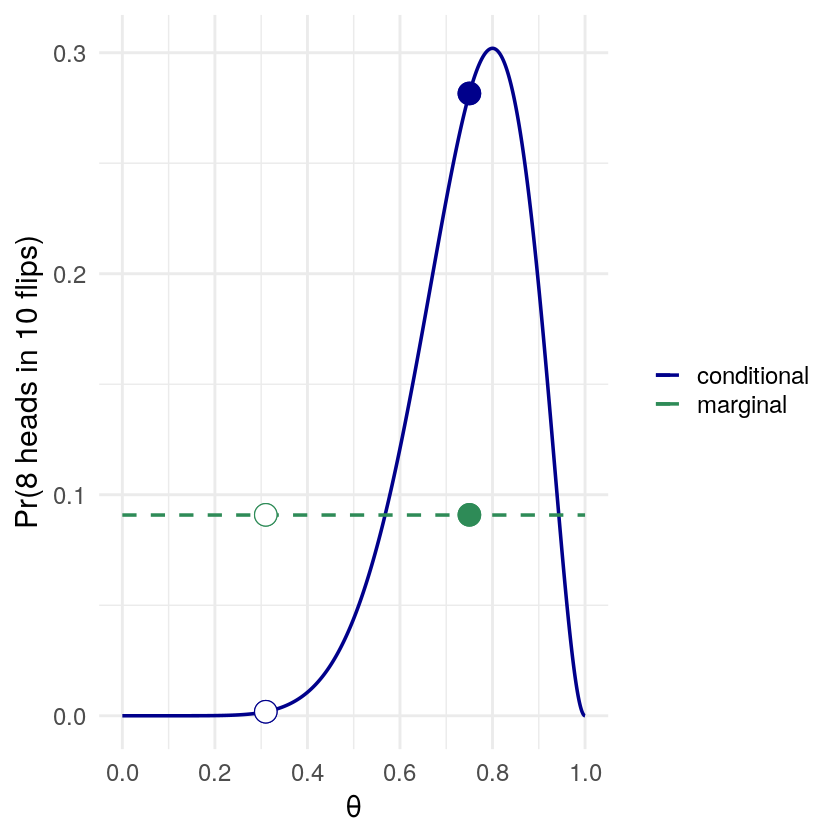

In [34]:
# 9
marginal_conditional_df = tibble(theta = c(seq(0,1, .001),thetas$theta),
    prob = dbinom(x = X, size = N, prob = c(seq(0,1,.001),thetas$theta))) %>%
mutate(highlight = theta %in% thetas$theta) %>% full_join(thetas, by = "theta")


marginal_prob = marginal_prob_tbl %>% pull(margin) %>% sum(na.rm = T) 
marginal_conditional_df$marginal_prob = marginal_prob
marginal_conditional_df %>%
ggplot(aes(x = theta, y = prob)) + geom_line(aes(colour = "conditional"), size = 1) + 
geom_line(aes(x = theta, y = marginal_prob, colour = "marginal"), linetype = 2, size = 1) + 
geom_point(. %>% filter(highlight == TRUE), mapping = aes(x = theta, y = prob, shape = `prior > posterior`), 
           size = 6, colour = "darkblue", fill = "white") +
geom_point(. %>% filter(highlight == TRUE), mapping = aes(x = theta, y = marginal_df %>% 
                                                          filter(x == X) %>% pull(marginal_prob),
                                                         shape = `prior > posterior`), size = 6, 
           fill = "white", colour = "seagreen") +
scale_shape_manual(values = c("TRUE" = 21, "FALSE" = 19), guide = "none") + 
scale_y_continuous(glue("Pr({X} heads in {N} flips)")) +
scale_x_continuous(name = "θ", breaks = seq(0,1,.2)) + theme_minimal(18) +
scale_color_manual(values = c("darkblue","seagreen"), name = NULL)

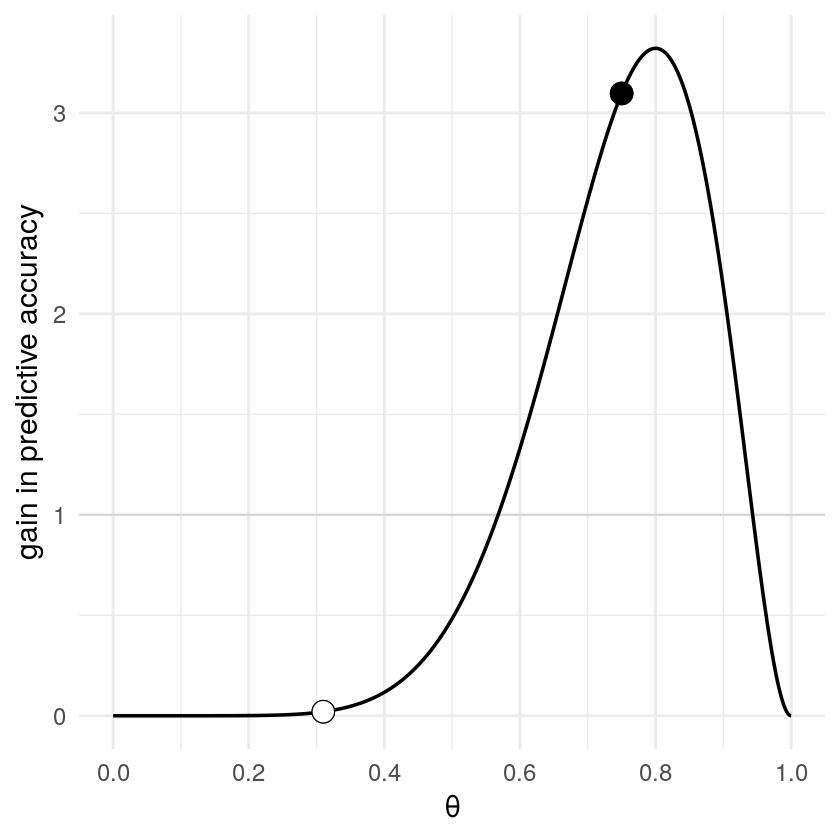

In [35]:
# 10
marginal_conditional_df %>% mutate(marginal =  marginal_df %>% filter(x == X) %>% pull(marginal_prob)) %>% 
mutate(predictive = prob / marginal) %>% 
ggplot(aes(x = theta, y = predictive)) + geom_line(size = 1) + 
geom_point(. %>% filter(highlight == TRUE), mapping = aes(x = theta, y = predictive,
                                                         shape = `prior > posterior`), size = 6, fill = "white") + 
scale_shape_manual(values = c("TRUE" = 21, "FALSE" = 19), guide = "none") + 
scale_y_continuous("gain in predictive accuracy") + geom_hline(yintercept = 1, alpha = .1) + 
scale_x_continuous(name = "θ", breaks = seq(0,1,.2)) + theme_minimal(base_size = 18) 

This plot **is just the same as the strength of evidence** for values of $\theta$ or the factor by which we update our beliefs about $\theta$ after observing the data. This fact is just represented by the equality in the ratio form of Bayes rule $\frac{\pi(\theta|Y)}{\pi({\theta})}=\frac{p(Y|\theta)}{p(Y)}$. This equation can now we read as meaning that the strength of evidence that we have for a parameter value is just the same as the gain in predictive accuracy. 

In this example, we've only considered one model defined by the prior we set at the beginning. However, marginal densities are particularly useful when we consider multiple models. In the next example, we plot the marginal density for our current model ($\mathcal{M}_1$; subplot **A**) and more restricted model where we no longer a probability distribution over every possible value of $\theta$, but instead only consider one possible value, $\theta$ = 0.5 ($\mathcal{M}_2$; subplot **A**). The difference in predictions the models make is shown in subplot **C**. This plot is just generated as the ratio $\frac{p(Y|\mathcal{M}_1)}{p(Y|\mathcal{M}_2)}$. Once we have our data in hand, we can see whether our data is better predicted by Model 1 or Model 2—this value is the **Bayes factor**.


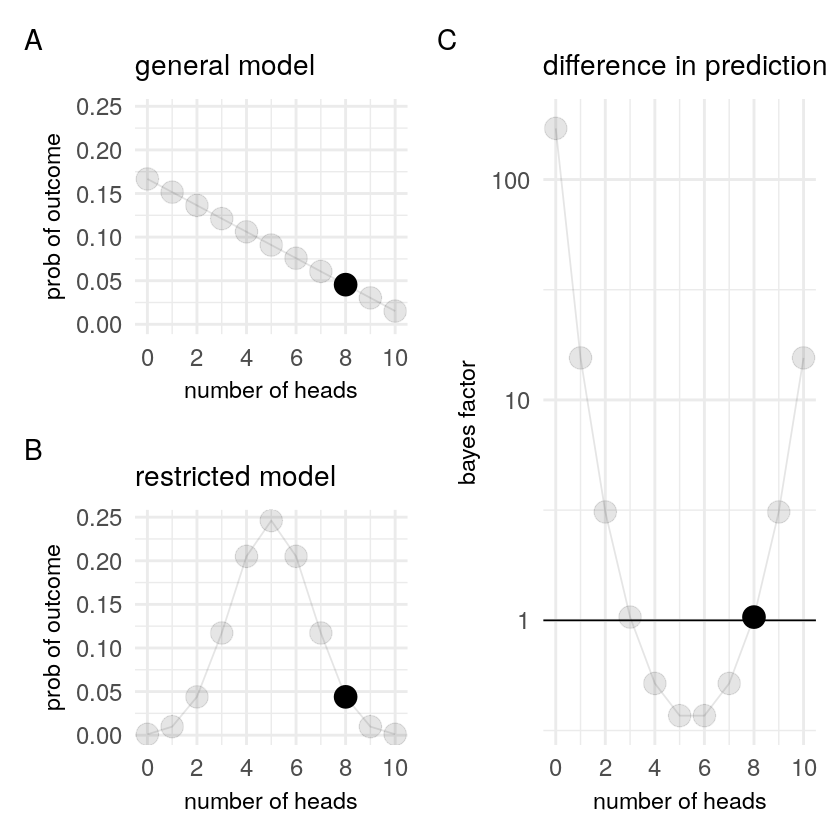

In [15]:
# 11

marginal_df_null = tibble(x = 0:N,
marginal_prob = map_dbl(.x = 0:N, .f = function(x) dbinom(x = x, size = N, prob = 0.5) * 1), ob = x == X)

                        
null_plot = marginal_df_null %>% ggplot(aes(x = x, y = marginal_prob)) + geom_point(aes(alpha = ob), size = 6) + 
geom_line(alpha = .1) +  scale_alpha_manual(values = c(.1,1), guide = "none") +
       scale_x_continuous(breaks = seq(0,N,2), name = "number of heads") +
scale_y_continuous(name = "p(Y)")  + theme_minimal(18)  

bf_plot = marginal_df %>% full_join(marginal_df_null, by = c("x","ob"), suffix = c(".general",".null")) %>% 
mutate(BF =  marginal_prob.general / marginal_prob.null) %>% 
ggplot(aes(x = x, y = BF)) + geom_point(aes(alpha = ob), size = 6) + 
geom_line(alpha = .1) +  scale_alpha_manual(values = c(.1,1), guide = "none") +
       scale_x_continuous(breaks = seq(0,N,2), name = "number of heads") +
scale_y_continuous(name = "bayes factor", trans = "log10") + 
geom_hline(yintercept = 1) + theme_minimal(18)  
                 
models = ((general_model_plot + labs(title = "general model")) / 
  null_plot + labs(title = "restricted model"))
                        
p_ranges_y <- c(ggplot_build(models[[1]])$layout$panel_scales_y[[1]]$range$range,
                ggplot_build(models[[2]])$layout$panel_scales_y[[1]]$range$range)
models = suppressMessages(models  & ylim(min(p_ranges_y), max(p_ranges_y)) & ylab("prob of outcome"))
                        
                       
((models | (bf_plot + labs(title = "difference in prediction") )) + plot_annotation(tag_levels = "A")) &
                        theme(title = element_text(size = 14))